# Exploratory Data Analysis - NYC Taxi Trip Duration

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
sns.set_theme()
sns.set_style('whitegrid')

In [3]:
# load data
from load_preprocess_data import load_train_data, load_test_data

# load data
train_data = load_train_data('data/W22P1_train.csv')
test_data = load_test_data('data/W22P1_test.csv')

# list of names of covariates
covariates = list(train_data.columns[:-2])


# sample points for plots since full dataset is too large for purposes of producing plots
sample_size = 500
sample_train_data = train_data.sample(sample_size)

train_data.head()

,pickup_datetime,dayofweek,hour,passenger_count,distance_km,l1_distance_km,bearing,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration
id,,,,,,,,,,,,,
0,2016-01-07 19:32:15,3,19,1,1.259700,1.687396,296.295673,-73.986389,40.756615,-73.999794,40.761631,520,6.253829
1,2016-01-27 08:07:32,2,8,1,2.356650,3.146872,334.240476,-73.956039,40.767609,-73.968201,40.786690,989,6.896694
2,2016-01-31 13:52:55,6,13,1,2.806862,3.948055,230.930933,-73.975998,40.751137,-74.001854,40.735229,657,6.487684
3,2016-01-19 08:00:19,1,8,3,3.155510,3.991410,198.443755,-73.960121,40.781952,-73.971970,40.755039,1035,6.942157
4,2016-01-25 23:32:14,0,23,1,1.725446,1.998249,189.977838,-73.987434,40.760139,-73.990982,40.744862,621,6.431331


## Distribution of `trip_duration` (Target Variable)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


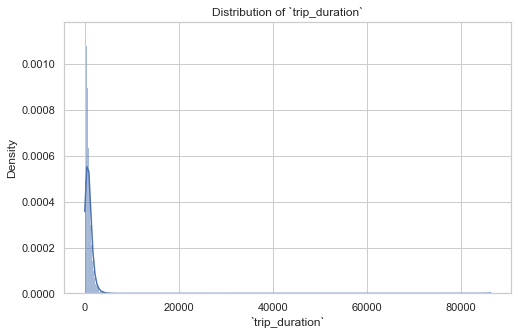

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data, x='trip_duration', kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of `trip_duration`');
ax.set_xlabel('`trip_duration`');

fig.savefig('figs/trip_duration_dist.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


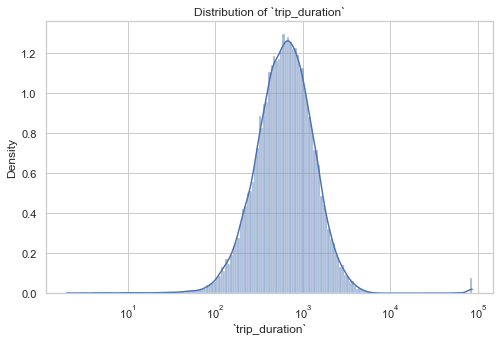

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data, x='trip_duration', kde=True, log_scale=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of `trip_duration`');
ax.set_xlabel('`trip_duration`');

fig.savefig('figs/trip_duration_log_dist.eps')

The logarithm of the trip durations looks to have a roughly normal distribution. Let's test this.

In [6]:
import scipy.stats
_, p = scipy.stats.normaltest(np.log10(train_data['trip_duration'].sample(1000).to_numpy()))
print('Normality test p-value: ', p)

Normality test p-value:  2.5163330508780074e-29


## Relationship Between Covariates

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


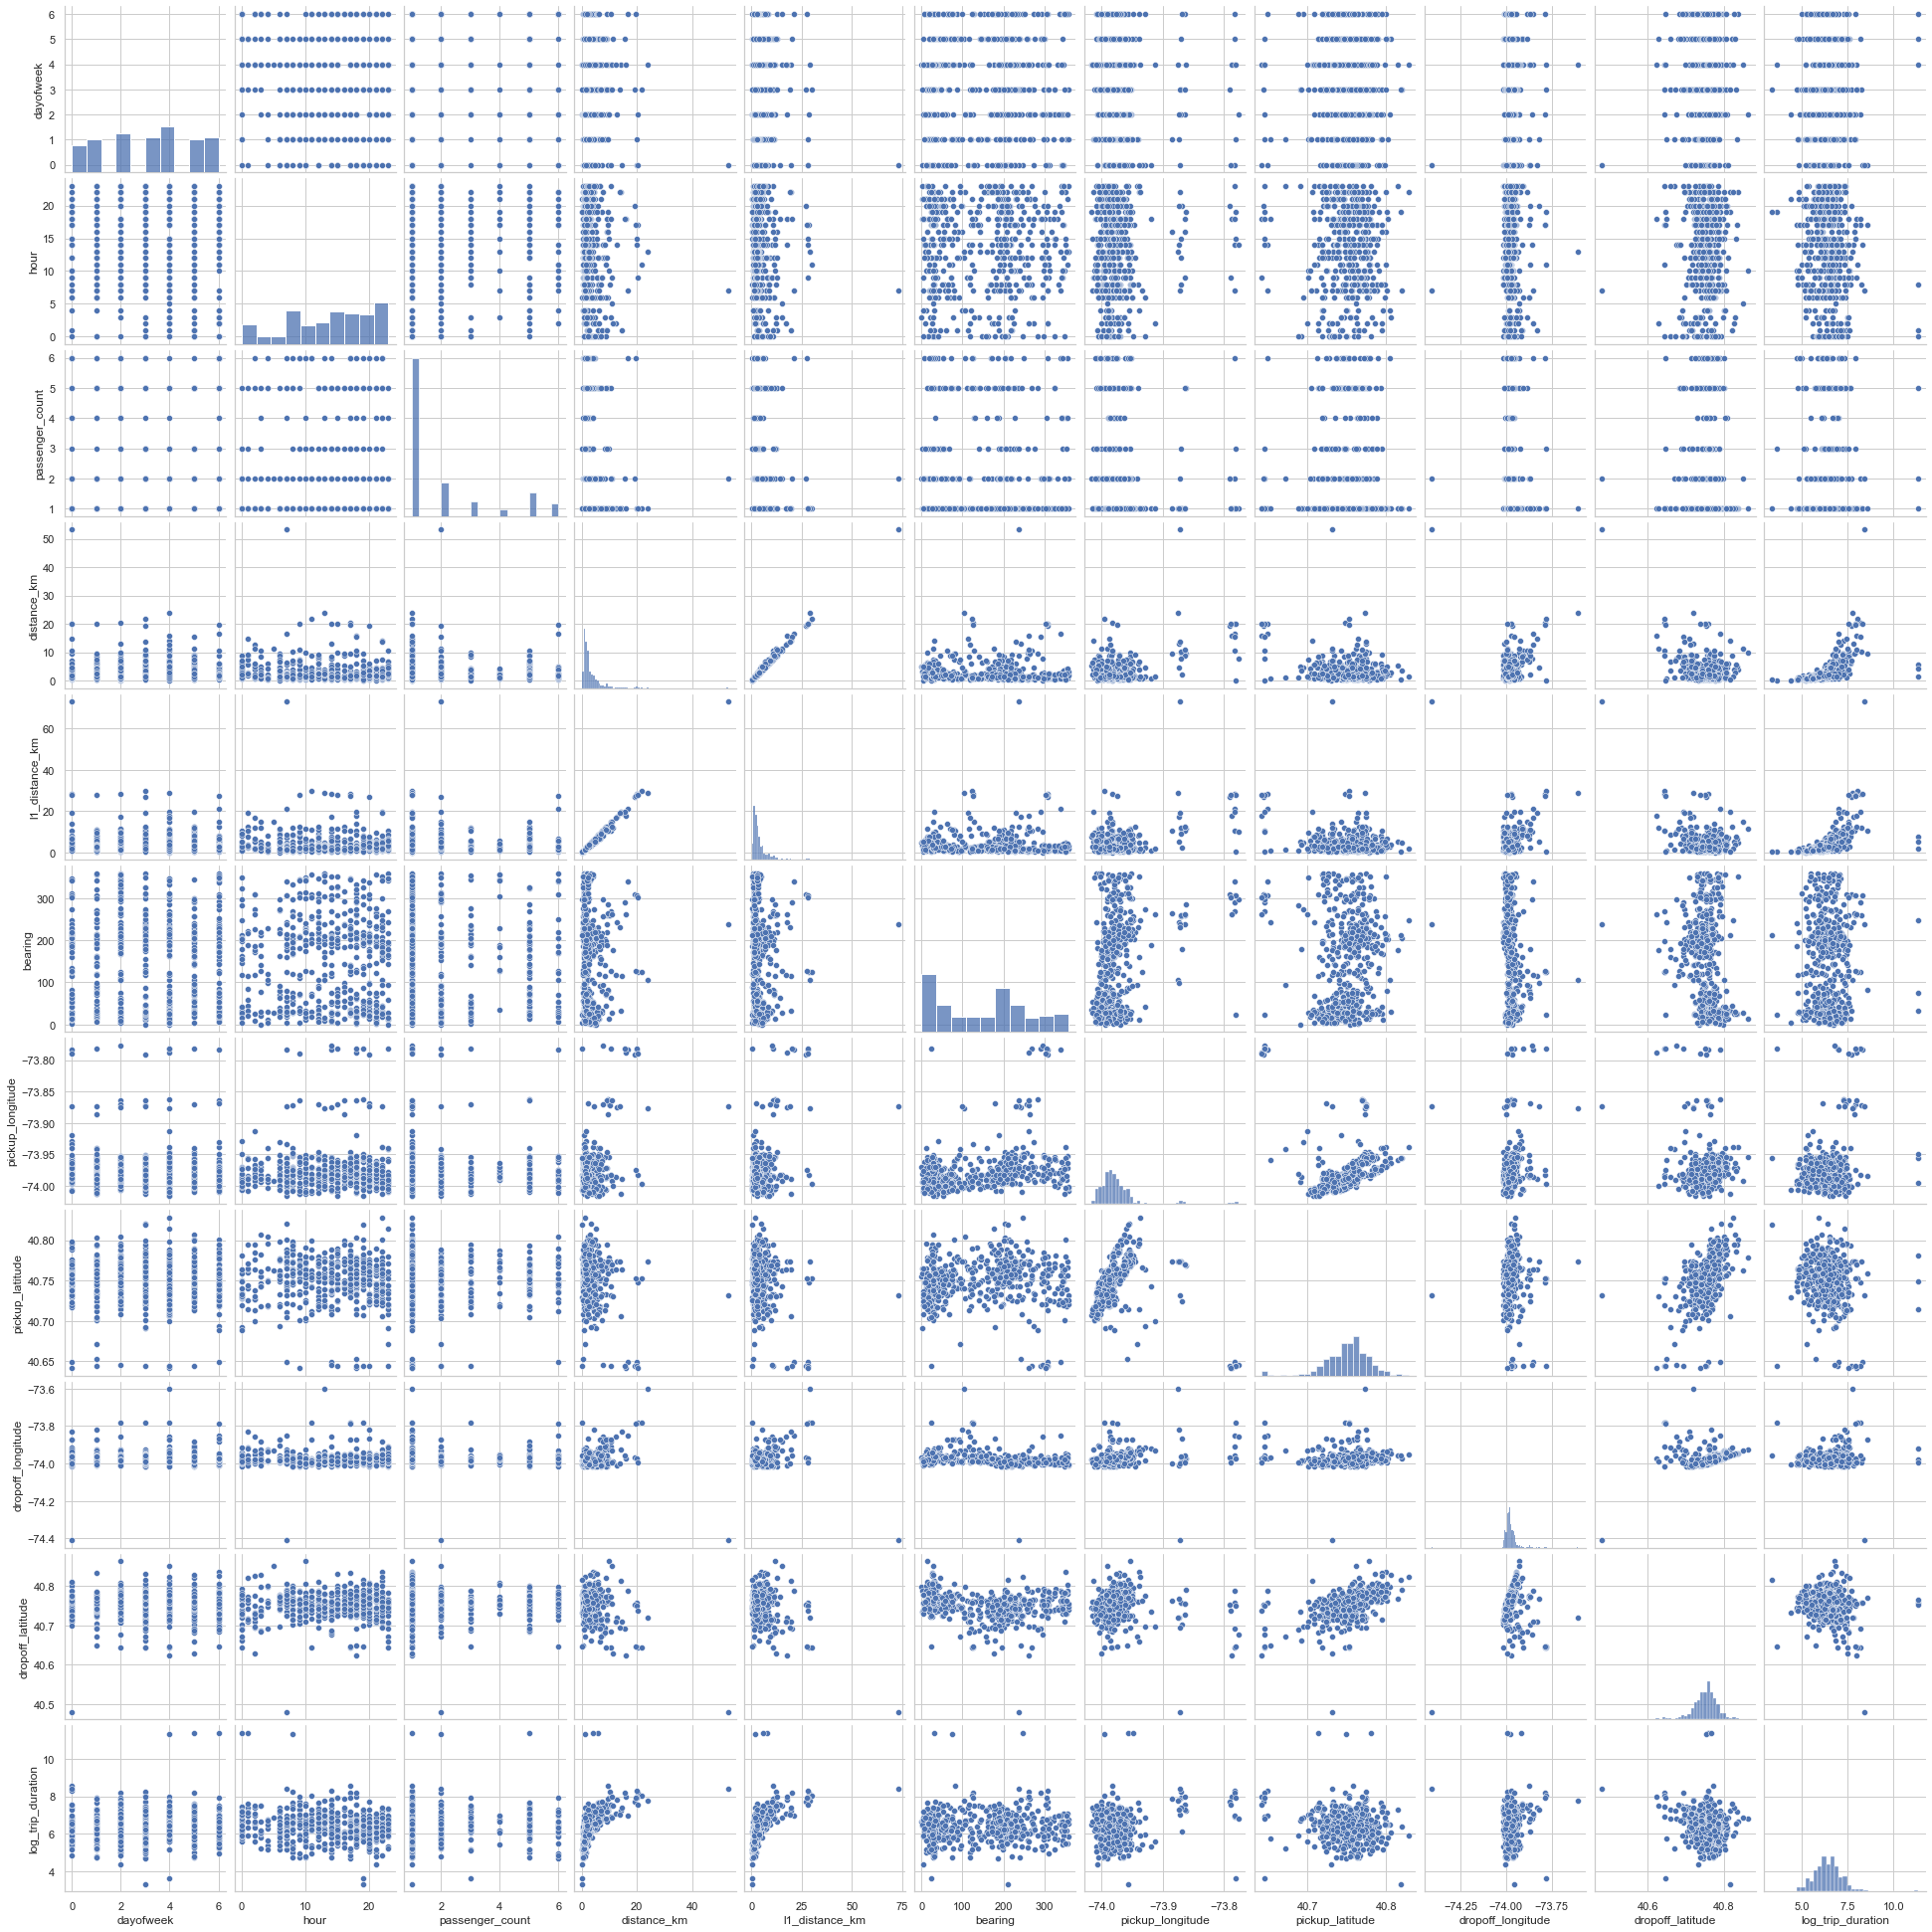

In [7]:
grid = sns.pairplot(data=sample_train_data[covariates+['log_trip_duration']]);
grid.savefig('figs/pairplot.eps')

## `trip_duration` as a function of pickup location

In [8]:
fig = px.scatter_mapbox(train_data.sample(1500), lat="pickup_latitude", lon="pickup_longitude", color="log_trip_duration",
                  opacity=0.65, color_continuous_scale='dense', zoom=11,
                  mapbox_style="carto-positron", width=800, height=800,
                  title="Effect of Pickup Location on Trip Duration")
fig.show()
fig.write_image('figs/pickup_trip_dur.svg')
fig.write_image('figs/pickup_trip_dur.png')

## `trip_duration` as a function of dropoff location

In [9]:
fig = px.scatter_mapbox(train_data.sample(1500), lat="dropoff_latitude", lon="dropoff_longitude", color="log_trip_duration",
                  opacity=0.65, color_continuous_scale='dense', zoom=11,
                  mapbox_style="carto-positron", width=800, height=800,
                  title="Effect of Pickup Location on Trip Duration")
fig.show()
fig.write_image('figs/dropoff_trip_dur.svg')
fig.write_image('figs/dropoff_trip_dur.png')

## Exploring Distance

**Hypothesis:** trip duration is correlated with the distance between the dropoff locations.

The pickup and dropoff locations are given in lattitude-logitude coordiantes, so we will need to use the Haversine distance.

In [10]:
sum(train_data['distance_km']==0)

154

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


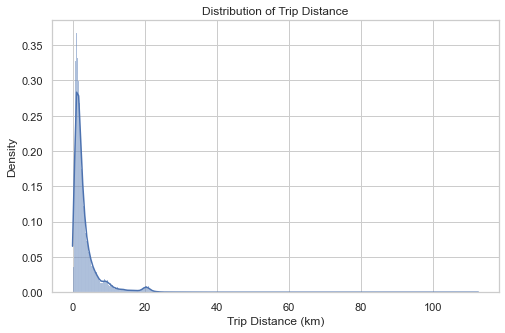

In [11]:
# distribution of distances
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data, x='distance_km', kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of Trip Distance');
ax.set_xlabel('Trip Distance (km)');

fig.savefig('figs/distance_km_dist.eps')

Weirdly, some trips have distance 0...

In [12]:
print(f'# of 0-distance trips: {sum(train_data.distance_km==0)} out of {len(train_data)}')

# of 0-distance trips: 154 out of 30000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


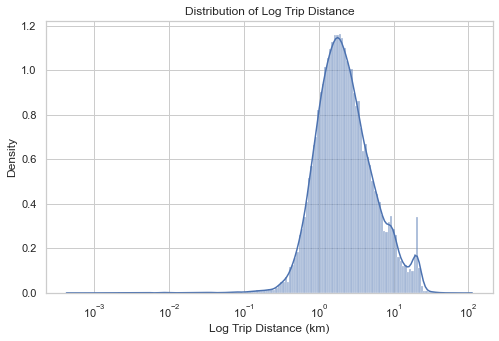

In [13]:
# distribution of log of distances
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data[train_data.distance_km>0], x='distance_km', log_scale=True, kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of Log Trip Distance');
ax.set_xlabel('Log Trip Distance (km)');

fig.savefig('figs/log_distance_km_dist.eps')

Now, let's explore the relationship between trip distance and trip duration...

C:\Users\awnya\AppData\Local\Temp\ipykernel_18160\611485157.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


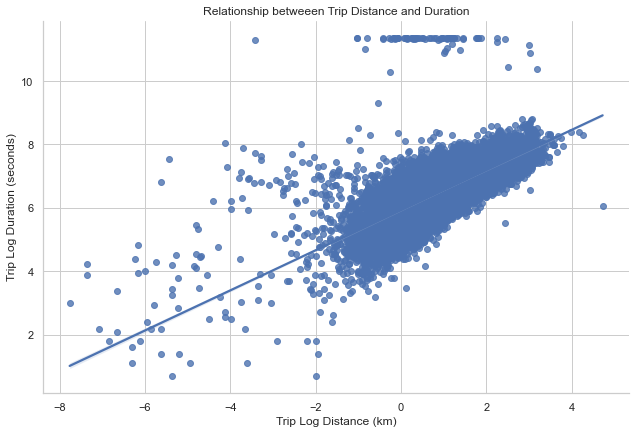

In [14]:
# Relationship between trip distance and duration

mask = train_data['distance_km'] != 0
train_data_ = train_data[mask]
train_data_['log_distance_km'] = np.log(train_data_['distance_km'])

distdurplot = sns.lmplot(x="log_distance_km", y="log_trip_duration", data=train_data_, height=6, aspect=1.5)

distdurplot.ax.set_title('Relationship betweeen Trip Distance and Duration');
distdurplot.ax.set_xlabel('Trip Log Distance (km)');
distdurplot.ax.set_ylabel('Trip Log Duration (seconds)');

distdurplot.savefig('figs/log_distance_duration_lm.eps')

Seems mostly follows a linear relationship, but there is a clump of outliers with short trips but long trip durations...

## L1 (Manhattan) Distance
Taxi's aren't taking a direct path to their destination, they're following the NYC grid. Thus, we might expect the L1 distance to be more strongly correlated with the trip duration than euclidean distance.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


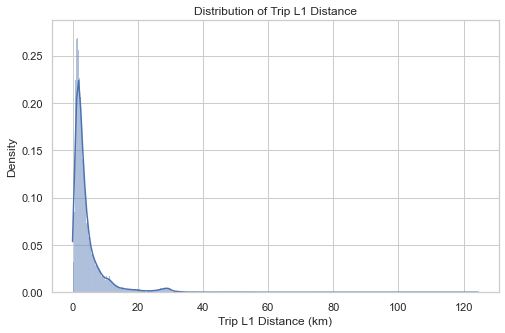

In [15]:
# distribution of L1 distances
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data, x='l1_distance_km', kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of Trip L1 Distance');
ax.set_xlabel('Trip L1 Distance (km)');

fig.savefig('figs/l1_distance_km_dist.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


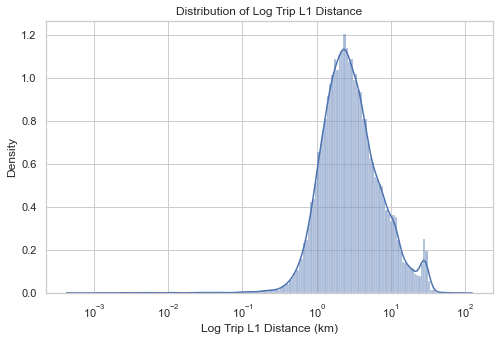

In [16]:
# distribution of log of L1 distances
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(data=train_data[train_data.distance_km>0], x='l1_distance_km', log_scale=True, kde=True, stat='density', element='bars', ax=ax);
ax.set_title('Distribution of Log Trip L1 Distance');
ax.set_xlabel('Log Trip L1 Distance (km)');

fig.savefig('figs/log_l1_distance_km_dist.eps')

C:\Users\awnya\AppData\Local\Temp\ipykernel_18160\1948001931.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


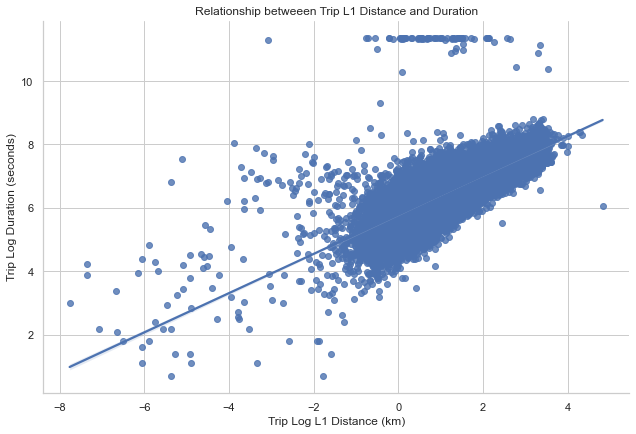

In [17]:
# Relationship between trip distance and duration

mask = train_data['l1_distance_km'] != 0
train_data_ = train_data[mask]
train_data_['log_l1_distance_km'] = np.log(train_data_['l1_distance_km'])

distdurplot = sns.lmplot(x="log_l1_distance_km", y="log_trip_duration", data=train_data_, height=6, aspect=1.5)
distdurplot.ax.set_title('Relationship betweeen Trip L1 Distance and Duration');
distdurplot.ax.set_xlabel('Trip Log L1 Distance (km)');
distdurplot.ax.set_ylabel('Trip Log Duration (seconds)');

distdurplot.savefig('figs/log_l1_distance_duration_lm.eps')

## Direction of Trip
**Hypothesis:** The direction or _bearing_ of the trip is correlated with trip duration.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


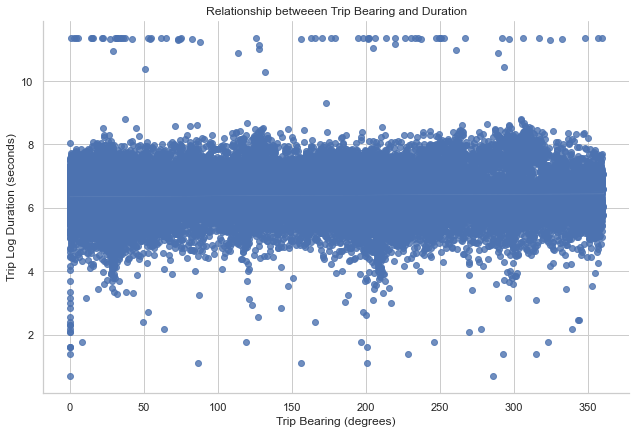

In [18]:
bearingdurplot = sns.lmplot(x="bearing", y="log_trip_duration", data=train_data, height=6, aspect=1.5)
bearingdurplot.ax.set_title('Relationship betweeen Trip Bearing and Duration');
bearingdurplot.ax.set_xlabel('Trip Bearing (degrees)');
bearingdurplot.ax.set_ylabel('Trip Log Duration (seconds)');

distdurplot.savefig('figs/bearing_duration_lm.eps')

## Making use of the month (seasonality)

In [19]:
print(f'First day: {min(train_data.pickup_datetime).date()}; Last day: {max(train_data.pickup_datetime).date()}')

First day: 2016-01-01; Last day: 2016-01-31


Actually, it turns out this data is all from January 2016. Perhaps we can look into using the day in the date, but I don't know how I feel about that. Seems like a recipe for overfitting. Day-of-week is a good feature to use though.

## Making use of the day-of-week

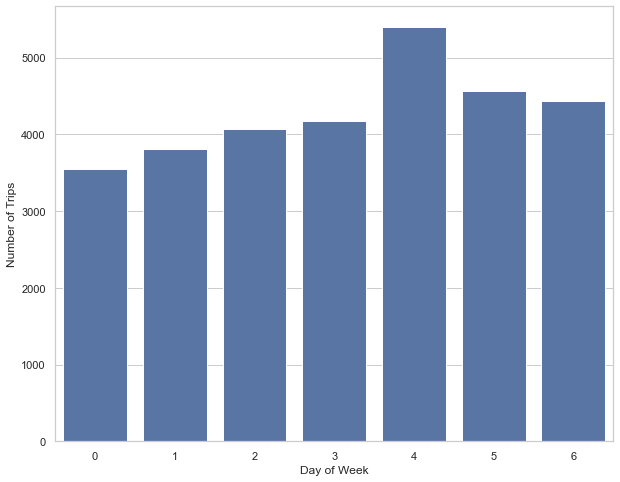

In [20]:
num_trips_day = train_data['dayofweek'].value_counts()

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=num_trips_day.index, y=num_trips_day, ax=ax, color='b')
ax.set_xlabel('Day of Week');
ax.set_ylabel('Number of Trips');
# ax.set_title('Relationship between Hour-of-Day and Trip Duration');

fig.savefig('figs/num_trips_day.eps')

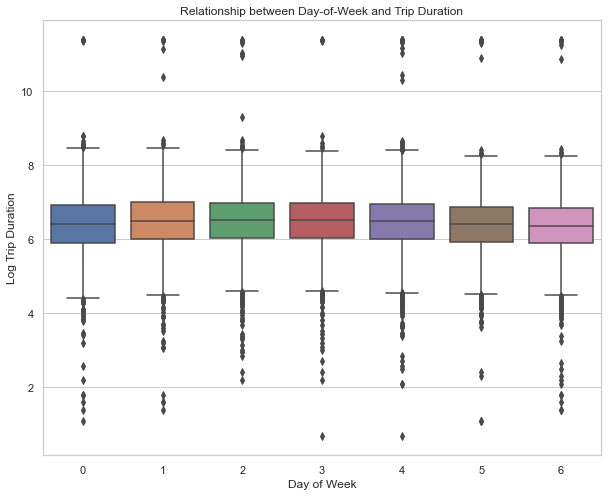

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='dayofweek', y='log_trip_duration', data=train_data, ax=ax);
ax.set_xlabel('Day of Week');
ax.set_ylabel('Log Trip Duration');
ax.set_title('Relationship between Day-of-Week and Trip Duration');

fig.savefig('figs/dayofweek_trip_dur.eps')

## Time-of-Day

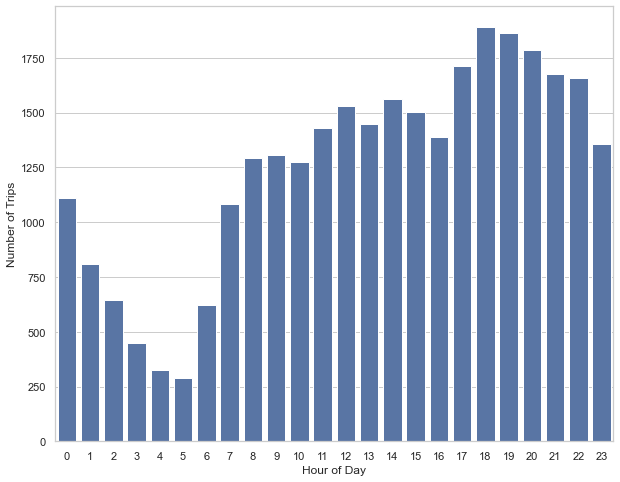

In [22]:
num_trips_hours = train_data['hour'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=num_trips_hours.index, y=num_trips_hours, ax=ax, color='b')
ax.set_xlabel('Hour of Day');
ax.set_ylabel('Number of Trips');
# ax.set_title('Relationship between Hour-of-Day and Trip Duration');

fig.savefig('figs/num_trips_hr.eps')

As expected, there are more trips at active times of day. Perhaps traffic has an effect on trip durations?

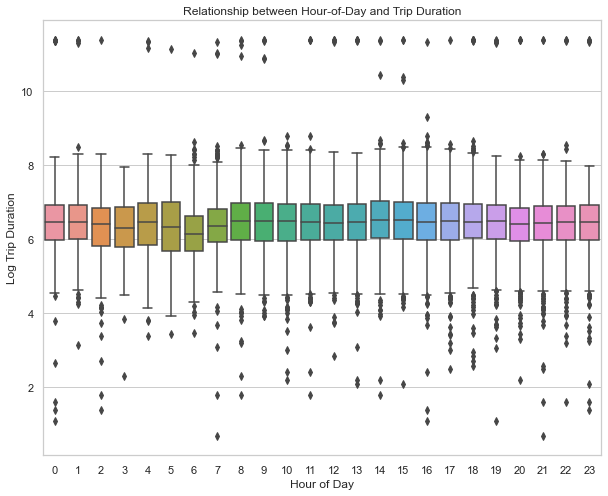

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=train_data, x="hour", y="log_trip_duration", ax=ax)
ax.set_xlabel('Hour of Day');
ax.set_ylabel('Log Trip Duration');
ax.set_title('Relationship between Hour-of-Day and Trip Duration');

fig.savefig('figs/hour_trip_dur.eps')